# Applying DeepLOB model to predict the results of horizon 50 for stock OPAP of Athex Exchange.

In [ ]:
# Importing the libraries.
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, CuDNNLSTM
from keras.models import Model
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)
print(tf.config.list_physical_devices())

2.9.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Data preparation

In [ ]:
# Functions to prepare the data for the model.
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:, k] - 1
    y = to_categorical(y, 3)
    return x, y


In [ ]:
# Load data
dec_data = np.loadtxt('train_OPAP_case1.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.9))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.9)):]
dec_test = np.loadtxt('test_OPAP_case1.txt')

k = 3 # Which horizon to use for prediction
T = 100 # The input dimension (time steps)
n_hiddens = 64
checkpoint_filepath = './opap_deeplob_k3/weights' # Where to save the model weights.

trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)

print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(20578, 100, 40, 1) (20578, 3)
(2199, 100, 40, 1) (2199, 3)
(11967, 100, 40, 1) (11967, 3)


# Model Architecture


In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(16, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(16, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(16, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(16, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(32, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(32, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(32, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(32, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(32, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.2, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)
    
    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)  # Change CuDNNLSTM to LSTM

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model
deeplob = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
deeplob.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 100, 20, 16)  48          ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)     (None, 100, 20, 16)  0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_15 (Conv2D)             (None, 100, 20, 16)  1040        ['leaky_re_lu_14[0][0]']   

# Model Training

In [ ]:
# Set up the checkpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
            epochs=50, batch_size=64, verbose=1, callbacks=[model_checkpoint_callback,early_stopping,reduce_lr])


Epoch 1/50
322/322 [==============================] - 37s 108ms/step - loss: 1.0391 - accuracy: 0.4356 - val_loss: 0.9367 - val_accuracy: 0.5166 - lr: 1.0000e-04
Epoch 2/50
322/322 [==============================] - 36s 113ms/step - loss: 1.0057 - accuracy: 0.4608 - val_loss: 0.9339 - val_accuracy: 0.5107 - lr: 1.0000e-04
Epoch 3/50
322/322 [==============================] - 38s 119ms/step - loss: 0.9977 - accuracy: 0.4689 - val_loss: 0.9258 - val_accuracy: 0.5339 - lr: 1.0000e-04
Epoch 4/50
322/322 [==============================] - 40s 123ms/step - loss: 0.9872 - accuracy: 0.4845 - val_loss: 0.9220 - val_accuracy: 0.5525 - lr: 1.0000e-04
Epoch 5/50
322/322 [==============================] - 40s 125ms/step - loss: 0.9628 - accuracy: 0.5173 - val_loss: 0.9476 - val_accuracy: 0.5452 - lr: 1.0000e-04
Epoch 6/50
322/322 [==============================] - 42s 129ms/step - loss: 0.9317 - accuracy: 0.5574 - val_loss: 0.9708 - val_accuracy: 0.5439 - lr: 1.0000e-04
Epoch 7/50
322/322 [========

# Model Testing

In [14]:
deeplob.load_weights(checkpoint_filepath)
pred = deeplob.predict(testX_CNN)

374/374 [==============================] - 11s 28ms/step


In [ ]:
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

accuracy_score: 0.5727417063591543
              precision    recall  f1-score   support

           0     0.4990    0.5405    0.5189      3578
           1     0.6756    0.5870    0.6282      4470
           2     0.5458    0.5859    0.5651      3919

    accuracy                         0.5727     11967
   macro avg     0.5734    0.5711    0.5707     11967
weighted avg     0.5803    0.5727    0.5749     11967



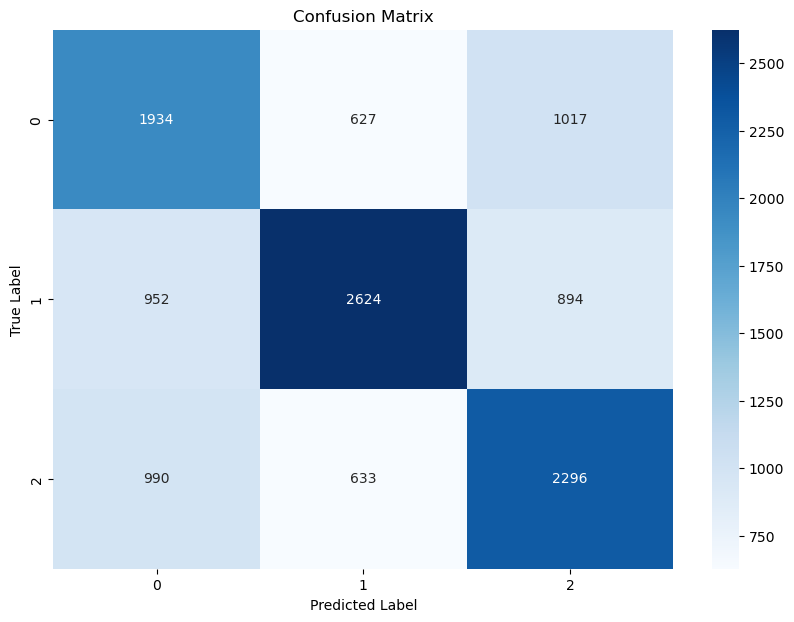

In [ ]:
# Convert one-hot encoded vectors to class labels
true_labels = np.argmax(testY_CNN, axis=1)
predicted_labels = np.argmax(pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)


# Plotting using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()